# Imports and File Reads

In [24]:
import pandas as pd
import numpy as np
# from dataprep.eda import create_report
from datetime import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score

In [12]:
# Rename filepath prefix for your respective folder hierarchies
filepath_prefix = 'dataset\\'

df_train_users = pd.read_csv(f'{filepath_prefix}train_users_2.csv')
df_test_users = pd.read_csv(f'{filepath_prefix}test_users.csv')
df_countries = pd.read_csv(f'{filepath_prefix}countries.csv')
df_age_bkts = pd.read_csv(f'{filepath_prefix}age_gender_bkts.csv')
df_sessions = pd.read_csv(f'{filepath_prefix}sessions.csv')

# Exploratory Data Analysis

## Age Bucket Distribution
Obtained from https://www.kaggle.com/code/asmaamohy/airbnb-eda

C:\Users\pawan\AppData\Local\Temp\ipykernel_16008\4040025584.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_age_bkts,x="country_destination",y="population_in_thousands",hue='age_bucket',ci=None,ax=ax)


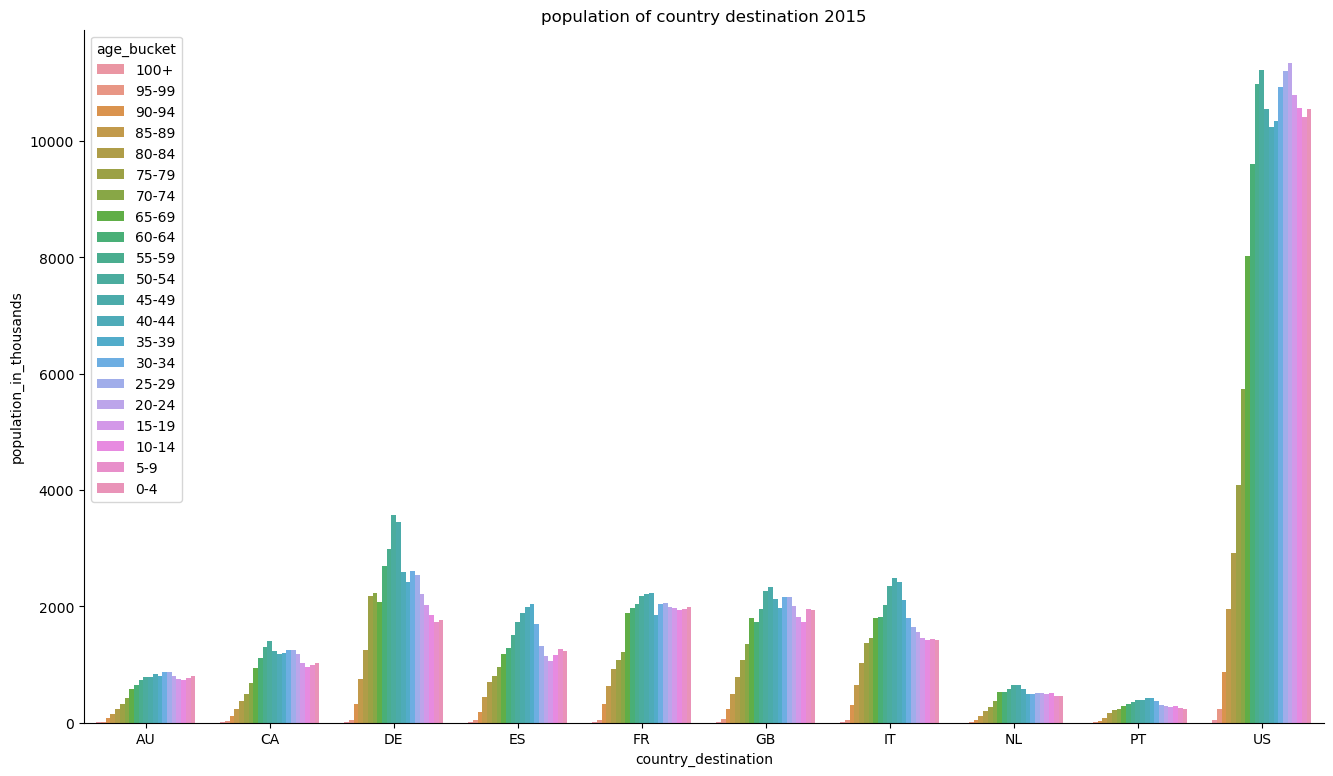

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
sns.barplot(data=df_age_bkts,x="country_destination",y="population_in_thousands",hue='age_bucket',ci=None,ax=ax)
plt.title('population of country destination 2015')
sns.despine()

## First Device vs Destination Country

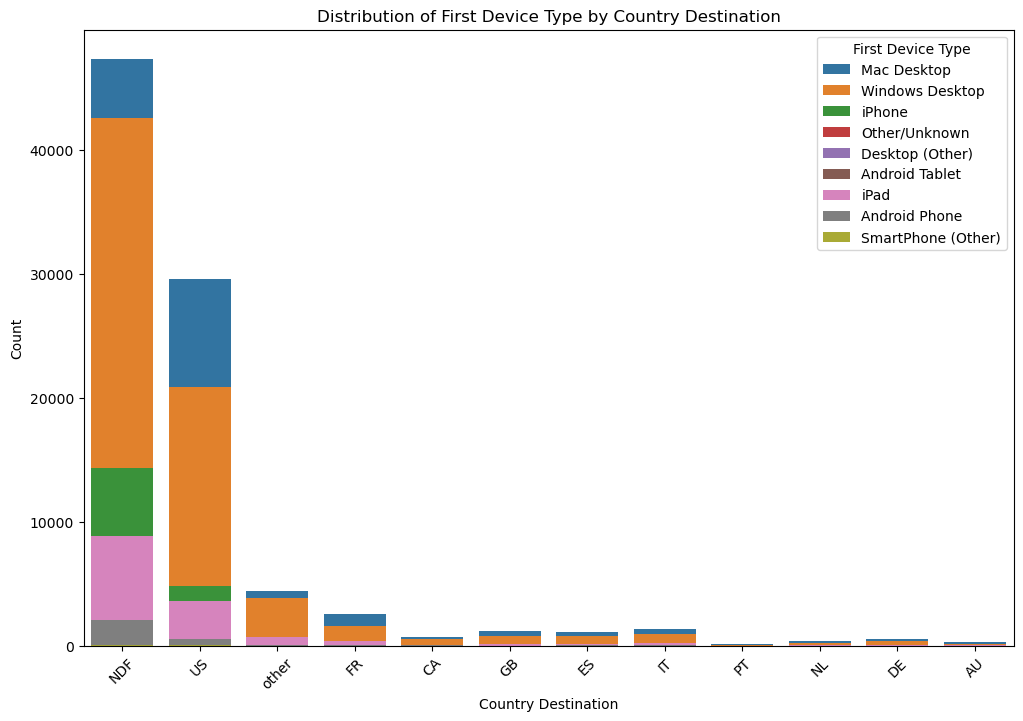

In [14]:
# Assuming df_train_users is your DataFrame
fig, ax = plt.subplots(figsize=(12, 8))

sns.countplot(data=df_train_users, x='country_destination', hue='first_device_type', dodge=False, ax=ax)

ax.set_title('Distribution of First Device Type by Country Destination')
ax.set_ylabel('Count')
ax.set_xlabel('Country Destination')
plt.xticks(rotation=45)
plt.legend(title='First Device Type')

plt.show()

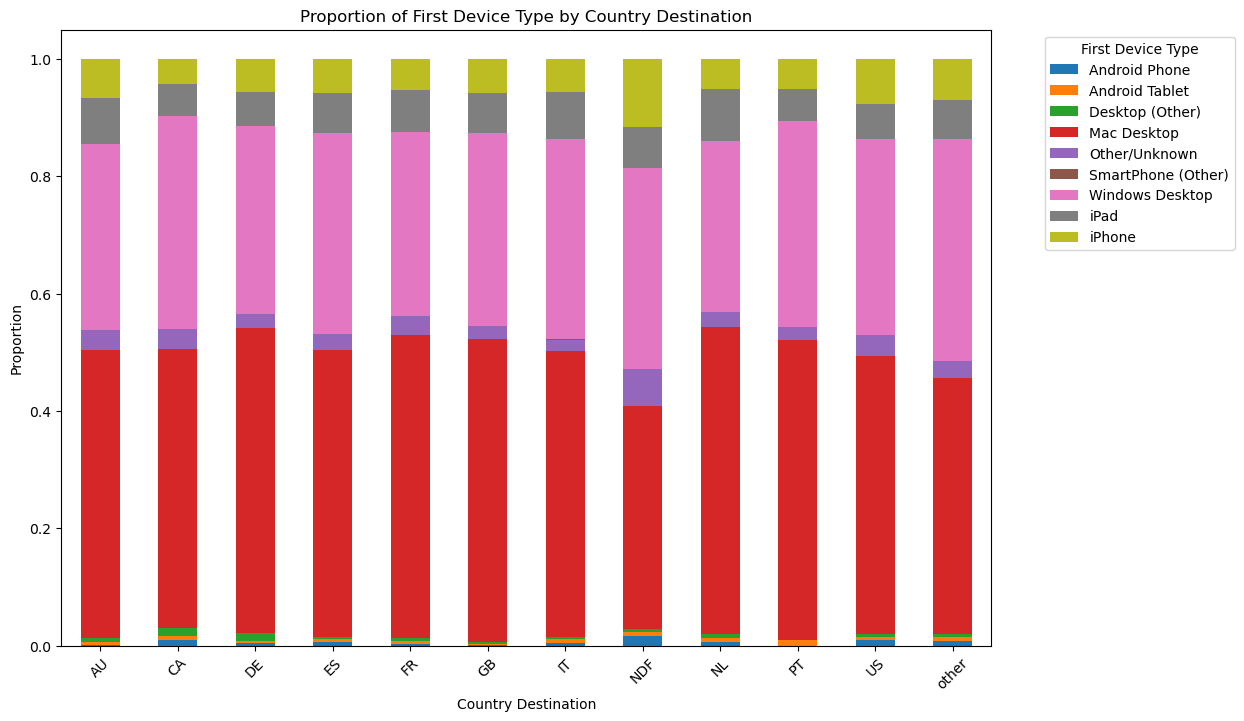

In [15]:
# Assuming df_train_users is your DataFrame
# Step 1: Calculate proportions
proportions = df_train_users.groupby(['country_destination', 'first_device_type']).size().reset_index(name='count')
total_counts = df_train_users['country_destination'].value_counts().reset_index()
total_counts.columns = ['country_destination', 'total_count']

proportions = proportions.merge(total_counts, on='country_destination')
proportions['proportion'] = proportions['count'] / proportions['total_count']

# Step 2: Create a pivot table
pivot_df = proportions.pivot_table(index='country_destination', columns='first_device_type', values='proportion', fill_value=0)

# Step 3: Plot the data
fig, ax = plt.subplots(figsize=(12, 8))
pivot_df.plot(kind='bar', stacked=True, ax=ax)

ax.set_title('Proportion of First Device Type by Country Destination')
ax.set_ylabel('Proportion')
ax.set_xlabel('Country Destination')
plt.xticks(rotation=45)
plt.legend(title='First Device Type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

# Data Cleaning

In [16]:
# Drop NA

df_train_users = df_train_users.dropna()
df_train_users.isna().sum()

id                         0
date_account_created       0
timestamp_first_active     0
date_first_booking         0
gender                     0
age                        0
signup_method              0
signup_flow                0
language                   0
affiliate_channel          0
affiliate_provider         0
first_affiliate_tracked    0
signup_app                 0
first_device_type          0
first_browser              0
country_destination        0
dtype: int64

<Axes: xlabel='age'>

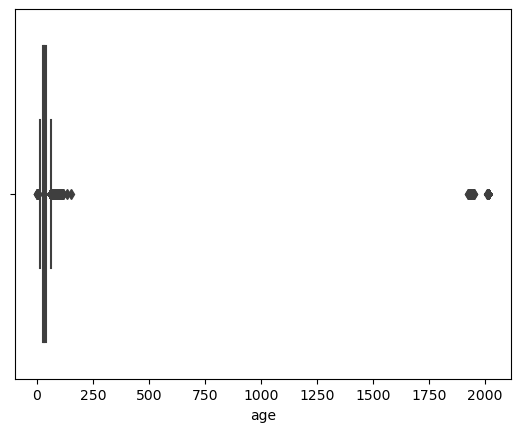

In [17]:
sns.boxplot(data=df_train_users, x='age')

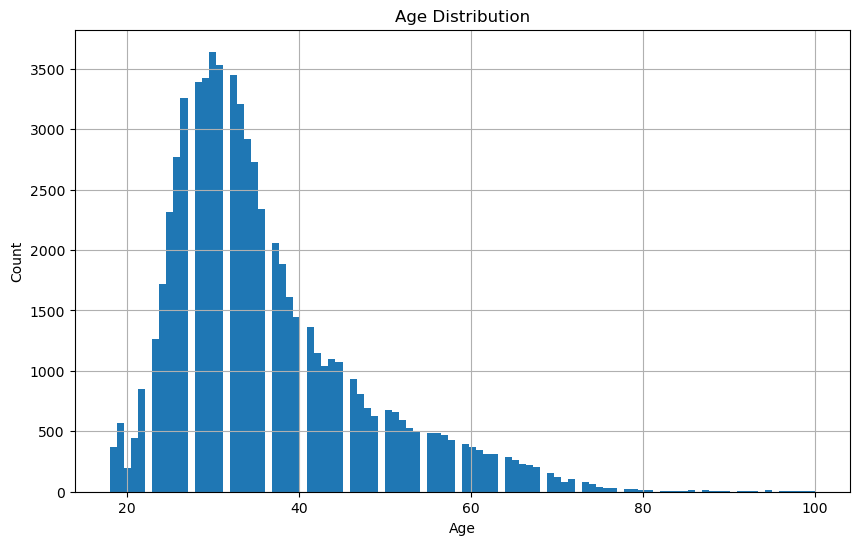

count    66853.000000
mean        36.141475
std         11.202717
min         18.000000
25%         28.000000
50%         33.000000
75%         41.000000
max        100.000000
Name: age, dtype: float64


In [19]:
# Adjust the weird ages. Seems like there are some years added to the age

ages = df_train_users['age'].copy()

ref_year = 2010 # "...users dataset dates back to 2010."
ages[(ages >= 1910) & (ages <= 1994)] = ref_year - ages[(ages >= 1910) & (ages <= 1994)]
ages[(ages < 16) | (ages > 100)] = np.nan

plt.figure(figsize=(10,6))
ages.hist(bins=100)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

print(ages.describe())

# replacing orginal age column with cleaned age column
df_train_users['age'] = ages

# Drop Ages < 18, it is AirBnB policy that minimum age of users should be 18

df_train_users = df_train_users[df_train_users['age'] >= 18]

# Modeling

## Ensemble Classifier

## K-Means

In [35]:
def execute_k_means_cluster (df, num_clusters):

    numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = df.select_dtypes(include=['object']).columns

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('cluster', KMeans(n_clusters=num_clusters))])

    model = clf.fit(df)
    
    # Extract cluster labels and inertia
    labels = model.named_steps['cluster'].labels_
    inertia = model.named_steps['cluster'].inertia_
    
    # Transform data and calculate silhouette score
    transformed_data = preprocessor.transform(df)
    silhouette = silhouette_score(transformed_data, labels)
    
    return {
        'model' : model,
        'labels' : labels,
        'distortion' : inertia,
        'silhouette_score' : silhouette
    }
    
k_means_cluster_results = {}
num_clusters_range = range(3, 14)

for cluster in num_clusters_range:
    k_means_cluster_results[cluster] = execute_k_means_cluster(df_train_users.drop('id', axis=1), cluster)
    print(f"Silhouette score for {cluster} clusters = {k_means_cluster_results[cluster]['silhouette_score']}")
   

c:\Users\pawan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette score for 3 clusters = 0.11076262799624517


c:\Users\pawan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette score for 4 clusters = 0.11213478131905748


Silhouette score for 3 clusters = 0.11076262799624517
Silhouette score for 4 clusters = 0.11213478131905748


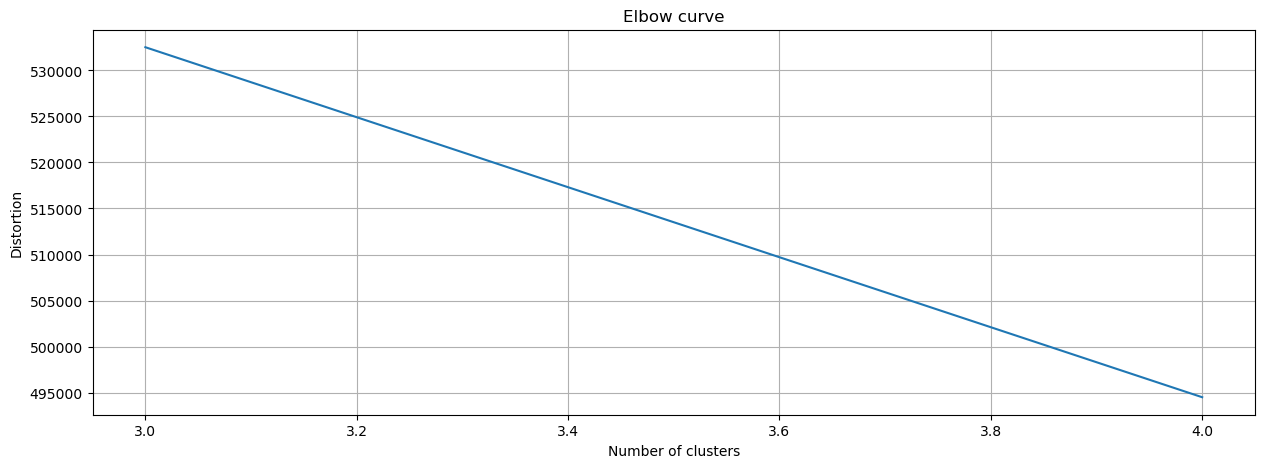

In [36]:
# Print Silhouette Score

for cluster in num_clusters:
    print(f"Silhouette score for {cluster} clusters = {k_means_cluster_results[cluster]['silhouette_score']}")
    
# Extracting distortions for different k values
distortions = [k_means_cluster_results[cluster]['distortion'] for cluster in num_clusters_range]

fig = plt.figure(figsize=(15, 5))
plt.plot(num_clusters_range, distortions)
plt.grid(True)
plt.title('Elbow curve')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()